# Assignment 2: SoC Module Recommender System

## Instructions to submit the assignment

- Name your jupyter notebook as `Assignment2_[StudentID].ipynb`. For instance: `Assignment2_A0123873A.ipynb`
- Your solution notebook must contain the python code that we can run to verify the answers.
  - late within 1 hour: 10% reduction in grade
  - late within 6 hours: 30% reduction in grade
  - late within 12 hours: 50% reduction in grade
  - late within 1 days: 70% reduction in grade
  - after 1 days: zero mark
- **This is an individual assessment. Refrain from working in groups.**

In this assignment we design a recomendation engine (Don't worry about the effectiveness of the system. It maybe very bad. The idea is just to offer you a proof of concept!). The recommendation engine suggests the students a module that closely matches the modules already taken by the student. The dataset comprices of two files:
- List of modules in the School of Computing 
- List of graduated students and the modules they had taken during their studies

# Loading the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
import warnings
warnings.filterwarnings("ignore")
'''
    YOU MUST USE THE RANDOM SEED WHEREVER NEEDED
'''
rng = np.random.RandomState(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
courses = pd.read_csv("/content/drive/MyDrive/IT5006/Assignment2/courses.tsv", sep='\t')
students = pd.read_csv("/content/drive/MyDrive/IT5006/Assignment2/students.tsv", sep='\t')

In [4]:
courses

,code,name,credits,workload,info,specialisation
0,CS1010,Programming Methodology,4,2-1-1-3-3,This module introduces the fundamental concept...,Core
1,CS1010FC/X,Programming Methodology,4,2-1-1-3-3,This module introduces the fundamental concept...,Core
2,CS1010E,Programming Methodology,4,2-1-1-3-3,This module introduces the fundamental concept...,Core
3,CS1010J,Programming Methodology,4,2-1-1-3-3,This module introduces the fundamental concept...,Core
4,CS1010S,Programming Methodology,4,2-1-1-3-3,This module introduces the fundamental concept...,Core
...,...,...,...,...,...,...
179,CS6281,Topics in Computer Science II,4,3-0-0-3-4,Topics will be of an advanced computer science...,NaN
180,CS6282,Topics in Computer Science III,4,3-0-0-3-4,Topics will be of an advanced computer science...,NaN
181,CS6283,Topics in Computer Science IV,4,3-0-0-3-4,Topics will be of an advanced computer science...,NaN
182,CS6284,Topics in Computer Science V,4,3-0-0-3-4,Topics will be of an advanced computer science...,NaN


In [5]:
students

,Unnamed: 0,GPA Range,Degree,Specialization,GPA,courses
0,0,4,1,3,4.072043,"CS5422,CS5223,CS4237,CS3281,CS6213,CS6211,CS32..."
1,1,4,1,1,4.919584,"CS6206,CS3241,CS5237,CS4350,CS3242,CS3281,CS42..."
2,2,4,1,0,4.628680,"CS5244,CS6270,CS6234,CS5223,CS3230,CS3284,CS22..."
3,3,4,1,1,4.018812,"CS5422,CS3220,CS3103,CS4224,CS4237,CS5248,CS32..."
4,4,3,0,1,3.340982,"CS6206,CS3241,CS5240,CS4350,CS5343,CS6243,CS62..."
...,...,...,...,...,...,...
995,995,4,0,3,4.753689,"CS6206,CS5238,CS4223,CS6211,CS5250,CS5224,CS53..."
996,996,4,0,1,4.763808,"CS2309,CS4215,CS1010FC/X,CS3211,CS5271,CS1281,..."
997,997,4,0,4,4.947150,"CS4243,CS3241,CS6207,CS4350,CS5343,CS6241,CS62..."
998,998,3,0,1,3.084214,"CS5422,CS3220,CS4344,CS2107,CS3283,CS6205,CS32..."


In [6]:
courses.specialisation.unique()

array(['Core', 'DB', 'SE', 'PL', 'Networking', 'Multimedia', 'Security',
       nan, 'Parallel', 'Parallel, PL', 'Graphics', 'Algo', 'PL, SE',
       'AI', 'AI, DB', 'Algo, Networking, Parallel', 'Security, SE',
       'AI, Graphics', 'AI, Multimedia', 'Algo, Security', 'AI, PL',
       'Networking, Parallel', 'Algo, Graphics', 'Graphics, Multimedia',
       'DB, Security', 'Netoworking'], dtype=object)

In [7]:
#We find that there is a typo 'netoworking' which should be networking
courses.specialisation = courses.specialisation.replace('Netoworking','Networking')
courses.specialisation.unique()

array(['Core', 'DB', 'SE', 'PL', 'Networking', 'Multimedia', 'Security',
       nan, 'Parallel', 'Parallel, PL', 'Graphics', 'Algo', 'PL, SE',
       'AI', 'AI, DB', 'Algo, Networking, Parallel', 'Security, SE',
       'AI, Graphics', 'AI, Multimedia', 'Algo, Security', 'AI, PL',
       'Networking, Parallel', 'Algo, Graphics', 'Graphics, Multimedia',
       'DB, Security'], dtype=object)

# Question 1: Creating the preprocessing pipeline

We want to create a sklearn pipeline to efficiently preprocess the data and prepare it for training a model. We use three different features in the `courses` data: `specialisation`, `info` and `workload`. We want to represent every feature in a numeric form and merge them to form a feature vector for every course. We do so in the following way:
- `specialisation` represents one of the six levels of the module. For instance: CS2103 is a Software Engineering (SE) specialisation module. Encode this categorical feature into a vector. The decision of handling missing values is left to you! *(Hint: You can use `MultiLabelBinerizer` to do so.)*
- `info` provides a short discription of the module. We want to convert it into a vector using CountVectorizer. *Don't forget to remove the stopwords* while doing so.
-  `workload` states the intended distribution of workload over lectures, tutorials, labs and self study. We want to find the workload as the sum of individual workloads. For instnce: 3-1-1-3-2 workload transforms to 10 hours.

Provide implementation for three classes that help us build the pipeline. `transformed_courses` should be a numpy array of shape `[n_courses X n_features]`.

                                                                                                   (6 marks)

In [8]:
class WorkloadTransformer:        
    def fit(self, X, y = None, **fit_params):
        return self
    
    def transform(self, X, y = None, **fit_params):
        X = X.copy()
        X['workload'] = X['workload'].str.split('-')
        X['workload'] = X['workload'].apply(lambda x: sum([float(i) for i in x]))
        return X['workload'].values.reshape(-1,1)


In [9]:
class InfoTransformer:        
    def fit(self, X, y = None, **fit_params):
        self.vectorizer = CountVectorizer(stop_words='english')
        self.vectorizer.fit(X['info'])
        return self
    
    def transform(self, X, y = None, **fit_params):
        return self.vectorizer.transform(X['info']).toarray()

In [10]:
class SpecTransformer:        
    def fit(self, X, y = None, **fit_params):
        X = X.copy()
        X = X.dropna(axis=0, subset = ['specialisation'])
        X['specialisation_split'] = X['specialisation'].str.split(', ')
        self.binarizer = MultiLabelBinarizer()
        self.binarizer.fit(X['specialisation_split'])
        return self
    
    def transform(self, X, y = None, **fit_params):
        X = X.copy()
        X['specialisation'] = X['specialisation'].fillna(value='None')
        X['specialisation_split'] = X['specialisation'].str.split(', ')
        return self.binarizer.transform(X['specialisation_split'])

In [11]:
featureTransformer = FeatureUnion([
    ('workload_processing', Pipeline([('wrkld', WorkloadTransformer())])),
    ('info_processing', Pipeline([('info', InfoTransformer())])),
    ('spec_processing', Pipeline([('spec', SpecTransformer())])),
])

featureTransformer.fit(courses)
transformed_courses = featureTransformer.transform(courses)
print(transformed_courses.shape)

(184, 2124)


Now we prepare our testing data in the same way we preprocessed the course. `students` data comprises of 1000 students and a list of modules they have taken. 

Create `Xtest` and `Ytest` as two matrices. `Xtest`, of size `1000*5`, comprises of first five modules for every student in the list. `Ytest`, of size `1000*[remaining_modules]`, comprises of rest of the modules for every student in the list. 
We do so in order to assess the performance of the recommender. We assess the recommender based on its effectiveness to predict the modules given a list of five modules as the input.

For instance: 
- `Xtest[0] = ['CS2105', 'CS4222', 'CS6270', 'CS6205', 'CS4226']`
- `Ytest[0] = ['CS3282', 'CS6204', 'CS5223', 'CS3281', 'CS4344', 'CS5422', 'CS3237', 'CS5233']`.

<div align="right">(1 mark)</align>

In [12]:
Xtest = []
Ytest = []

for i in range(len(students)):
    Xtest.append(students['courses'][i].split(',')[:5])
    Ytest.append(students['courses'][i].split(',')[5:])

print(Xtest[0])
print(Ytest[0])



['CS5422', 'CS5223', 'CS4237', 'CS3281', 'CS6213']
['CS6211', 'CS3282', 'CS2100', 'CS2105', 'CS5250', 'CS3210']


For every student in `Xtest`, we need to transform the list of 5 modules to the feature space using the `featureTransformer` fit on the training data. For every module we will get a feature vector of size `n_features`. We add these feature vectors to get an aggregate feature vector for very student.

Write a function `getFeatureVector` that takes in the list of modules and `featureTransformer`. It returns the feature vector for the specified list of courses. For instance, `getFeatureVector(Xtest[0], featureTransformer)` will return a vector of size `n_features`.

<div align="right">(3 marks)</div>

In [13]:
def getFeatureVector(modules, featureTransformer):
    X = courses[courses['code'].isin(modules)]
    result = featureTransformer.transform(X).sum(axis=0)
    return result

getFeatureVector(Xtest[0], featureTransformer).shape

(2124,)

# Question 2: Content based recommender

We can use a model as simple as K-nearest neighbour (KNN) to perform a content based recommendation. If we provide a list of 5 modules to the recommender, it provide us a list of modules that are similar to the specified modules.

`sklearn` provides `NearestNeighbors` as well as `KNeighborsClassifier`, both of which have a similar functionality. `NearestNeighbors` provides as an easy functionality to predict a list of K nearest neighbours. Therefore, we prefer it over `KNeighborsClassifier`. If we want to find K nearest points to a datapoint`d`, we need to use `n_neighbors` as K + 1 because the list includes `d` itself.

You can now train the model using the training data, which comprises of `transformed_courses` and with their codes as the labels. 
<div align="right">(1 mark)</div>

In [14]:
K = 5
model = NearestNeighbors(algorithm = "brute", n_neighbors = K+1)
## Write your code here

training_data = pd.DataFrame(transformed_courses)
training_data.index = courses.code
model.fit(training_data)

NearestNeighbors(algorithm='brute', n_neighbors=6)

It is time to see our model in action. Let's see what modules our model reommends based on the modules taken by a student.

Write a function that takes in a *pre-trained* model of your choice as input and the list of modules. It returns the top-K recommendations of the model. Print the top 6 recommendations for the first student. 
<div align="right">(3 marks)</div>

In [15]:
def recommend(model, modulesTaken, k = 5):
    featureVector = getFeatureVector(modulesTaken, featureTransformer).reshape(1,-1)
    distances, indices = model.kneighbors(featureVector, n_neighbors=k)
    result = courses.iloc[indices[0]]['code'].values
    return result

print(recommend(model, Xtest[0], 6))

['CS3203' 'CS3205' 'CS5223' 'CS2020' 'CS3216' 'CS3217']


# Question 3: Recommender evaluation

Is this the model any good?. To do so, we use **precision** and **recall** as our metrics. `Ytest` consists of true labels for every students. Using those labels as the ground truth, compute the precision and recall for every student. Write a code that prints values of average precision and recall for a specific value of `K` over the `students` dataset. Print the value of average precision and average recall for `K= 10`.

                                                                                                     (2 marks)

In [16]:
# Write your code here
def avg_precision_recall(model, Xtest, Ytest, k):
    precision_score = []
    recall_score = []
    for i in range(len(Xtest)):
        recommend_courses = recommend(model, Xtest[i], k)
        ground_truth = Ytest[i]
        precision_score.append(len(set(recommend_courses) & set(ground_truth)) / len(recommend_courses))
        recall_score.append(len(set(recommend_courses) & set(ground_truth)) / len(ground_truth))
    return np.mean(precision_score), np.mean(recall_score)

avg_precision, avg_recall = avg_precision_recall(model, Xtest, Ytest, 10)
print('The average precision is', avg_precision)
print('The average recall is', avg_recall)

The average precision is 0.056900000000000006
The average recall is 0.05636079270316887


We observe that both precision and recall is not really great. The reason might be igh feature dimension, which may even be noisy. Append the exisiting `featureTransformer` with a PCA to reduce the dimension. 

Print the value of average precision and recall for `K= 10` after the introduction of PCA.

                                                                                                     (2 marks)

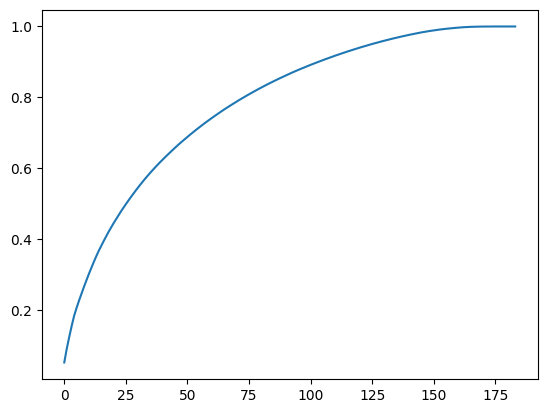

In [17]:
# Write your code here
pca = PCA(random_state=rng)
pca.fit(transformed_courses)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

We see from the graph that when the number of components is 125, it can explain about 95% of the variance, therefore we choose the number of components to be 125.

In [18]:
pca_feature_transformer = Pipeline([('featureTransformer', featureTransformer), ('pca', PCA(n_components=125, random_state=rng))])
pca_feature_transformer.fit(courses)

Pipeline(steps=[('featureTransformer',
                 FeatureUnion(transformer_list=[('workload_processing',
                                                 Pipeline(steps=[('wrkld',
                                                                  <__main__.WorkloadTransformer object at 0x7f7a9a383310>)])),
                                                ('info_processing',
                                                 Pipeline(steps=[('info',
                                                                  <__main__.InfoTransformer object at 0x7f7a9a383940>)])),
                                                ('spec_processing',
                                                 Pipeline(steps=[('spec',
                                                                  <__main__.SpecTransformer object at 0x7f7a9a3837c0>)]))])),
                ('pca',
                 PCA(n_components=125,
                     random_state=RandomState(MT19937) at 0x7F7A9A53EE40))])

In [19]:
K = 10
pca_model = NearestNeighbors(algorithm = "brute", n_neighbors = K+1)
transformed_courses_pca = pca_feature_transformer.transform(courses)
training_data = pd.DataFrame(transformed_courses_pca)
training_data.index = courses.code

pca_model.fit(training_data.values)

NearestNeighbors(algorithm='brute', n_neighbors=11)

In [20]:
def pca_recommend(model, modulesTaken, k = 5):
    featureVector = getFeatureVector(modulesTaken, pca_feature_transformer).reshape(1,-1)
    distances, indices = pca_model.kneighbors(featureVector, n_neighbors=k)
    return courses.iloc[indices[0]]['code'].values

def pca_avg_precision_recall(model, Xtest, Ytest, k):
    precision_score = []
    recall_score = []
    for i in range(len(Xtest)):
        pca_recommend_courses = pca_recommend(model, Xtest[i], k)
        ground_truth = Ytest[i]
        precision_score.append(len(set(pca_recommend_courses) & set(ground_truth)) / len(pca_recommend_courses))
        recall_score.append(len(set(pca_recommend_courses) & set(ground_truth)) / len(ground_truth))
    return np.mean(precision_score), np.mean(recall_score)

pca_avg_precision, pca_avg_recall = pca_avg_precision_recall(model, Xtest, Ytest, 10)
print('The average precision after pca is', pca_avg_precision)
print('The average recall after pca is', pca_avg_recall)

The average precision after pca is 0.1165
The average recall after pca is 0.12412893328721503


Extend the code to perform a grid search for the value of `K` that provides the best `F1_score`. Try for values of K from 1 to 10.

                                                                                                     (2 marks)

In [21]:
# Write your code here
def calculate_F1(precision, recall):
    return (2 * precision * recall)/ (precision + recall)

F1_score_list = []

for K in range(1,11):
    pca_avg_precision_score, pca_avg_recall_score = pca_avg_precision_recall(pca_model, Xtest, Ytest, K)
    F1_score = calculate_F1(pca_avg_precision_score, pca_avg_recall_score)
    F1_score_list.append(F1_score)

In [22]:
max_value = max(F1_score_list)
max_k = np.argmax(F1_score_list) + 1
print('The F1 score for K from 1 to 10 is' ,F1_score_list)
print('The best F1 score is', max_value)
print('The value K that provides the best F1_score is', max_k)

The F1 score for K from 1 to 10 is [0.007122289477796296, 0.010848343632195463, 0.018505911310868015, 0.024278702072831775, 0.03573484731092714, 0.05244583089999401, 0.07222247017661457, 0.09284173495442985, 0.10672292346945458, 0.12019353226072658]
The best F1 score is 0.12019353226072658
The value K that provides the best F1_score is 10
